In [8]:
# MLB Attendance Data - DATA 301 Final Project

In [9]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import time

In [10]:
team_names = {"ARI": ["ARI"],
              "ATL": ["ATL", "MLN", "BSN"], 
              "BAL": ["BAL", "SLB", "MLA"], 
              "BOS": ["BOS"], 
              "CHC": ["CHC"], 
              "CHW": ["CHW"], 
              "CIN": ["CIN"], 
              "CLE": ["CLE"], 
              "COL": ["COL"], 
              "DET": ["DET"], 
              "HOU": ["HOU"], 
              "KCR": ["KCR"], 
              "LAA": ["LAA", "ANA", "CAL"], 
              "LAD": ["LAD", "BRO"], 
              "MIA": ["MIA", "FLA"], 
              "MIL": ["MIL", "SEP"],
              "MIN": ["MIN", "WSH"], 
              "NYM": ["NYM"],
              "NYY": ["NYY"],
              "OAK": ["OAK", "KCA", "PHA"],
              "PHI": ["PHI"],
              "PIT": ["PIT"],
              "SDP": ["SDP"],
              "SFG": ["SFG", "NYG"], 
              "SEA": ["SEA"], 
              "STL": ["STL"], 
              "TBD": ["TBD", "TBR"],
              "TEX": ["TEX", "WSA"], 
              "TOR": ["TOR"],
              "WSN": ["WSN", "MON"]
              }

teams = dict.fromkeys(team_names)

In [142]:
for key in team_names.keys():
    games = []
    print(key)
    for year in range(2000,2016):
        for team in team_names[key]:
            url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + "-schedule-scores.shtml"
            page = requests.get(url)
            season = BeautifulSoup(page.text, "html.parser")

            table = season.find("div", {"id": "div_team_schedule"},class_="table_container")
            if table is not None:
                table = table.find_all("tr", class_="")
                for row in table[1:-1]:
                    if "thead" not in row["class"]:
                        values = row.find_all("td")
                        games.append({
                                "Date": values[2].text.split()[2] + " " + values[2].text.split(" ")[1] + " " + str(year),
                                "Year": year,
                                "DOW" : values[2].text.split(" ")[0][0:-1],
                                "Month" : values[2].text.split(" ")[1],
                                "Opp" : values[6].text,
                                "W/L" : values[7].text[0],
                                "Game" : values[1].text,
                                "WO" : "Y" if len(values[7].text) > 1 else "N",
                                "GB" : 0 if "Tied" in values[13].text 
                                        else (values[13].text).replace(" ", "").replace("up", "-"),
                                "Time" : values[18].text,
                                "Attendance" : values[19].text.replace(",", ""),
                                "Streak" : len(values[20].text),
                                "Home" : values[5].text,
                                "Pct" : 0 if (float(values[11].text.split("-")[0]) + float(values[11].text.split("-")[1])) == 0 
                                            else float(values[11].text.split("-")[0]) / (float(values[11].text.split("-")[0]) + float(values[11].text.split("-")[1])),
                                "RS" : int(values[8].text),
                                "RA" : int(values[9].text),
                                "Pitcher" : (values[14].find("a")["title"] if values[14].find("a") is not None else "") 
                                            if values[7].text[0] == "W" else (values[15].find("a")["title"] if values[15].find("a") is not None else ""),
                                "OPitcher" : (values[15].find("a")["title"] if values[15].find("a") is not None else "") 
                                            if values[7].text[0] == "W" else (values[14].find("a")["title"] if values[14].find("a") is not None else ""),
                                "Team" : team,
                            })
                break

            time.sleep(0.1)
    d = pd.DataFrame(games)
    if "Attendance" in d:
        d["Attendance"] = pd.to_numeric(d["Attendance"])
    teams[team] = d

LAA
LAD
NYM
HOU
MIN
TEX
SEA
STL
ARI
TBD
WSN
SFG
OAK
PHI
DET
KCR
SDP
CLE
CIN
CHW
CHC
NYY
ATL
MIA
MIL
PIT
TOR
COL
BAL
BOS


In [143]:
copy = teams.copy()

In [144]:
# CLEANING UP THE MESS THAT IS THE TAMPA BAY RAYS
if "TBR" in teams:
    teams["TBD"] = teams["TBR"] 
    del teams["TBR"]

In [145]:
import json

# FOR SAVING JSON FILES
for team in teams.keys():
    with open(team + '.json', 'w') as f:
            json.dump(teams[team].to_json(), f)

In [131]:
# LOAD JSON FILES TO NOTEBOOK
for team in teams.keys():
    with open(team + '.json', 'r') as f:
        try:
            teams[team] = pd.read_json( json.load(f) )
        # if the file is empty the ValueError will be thrown
        except ValueError:
            teams[team] = {}

In [150]:
# sfg["Game"].unique() <-- make sure to check there's 162 games, in case of postseason games being included!
sfg = teams["SFG"]
sfg["OVERALL_GAME"] = pd.to_numeric(sfg.reset_index()["index"]) + 1

sfg["Date"] = pd.to_datetime(sfg["Date"], format='%d %b %Y')

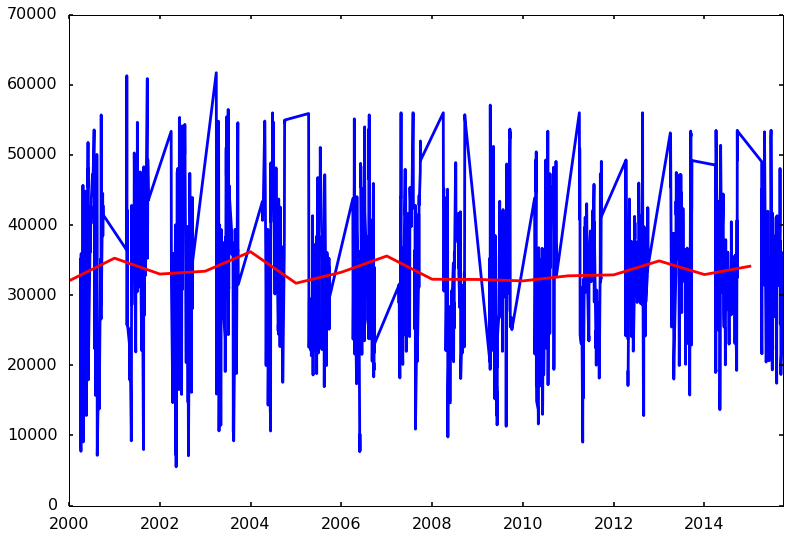

In [194]:
# ATTENDANCE OVER TIME (GROUPED BY MONTHLY AVERAGE)

import matplotlib.pyplot as plt
%matplotlib inline

sfg_monthly = teams["SFG"][teams["SFG"]["Home"] == "@"].sort_values("Date")
plt.style.use("seaborn-poster")
plt.plot(sfg_monthly["Date"], sfg_monthly["Attendance"])

new = sfg_monthly.groupby("Year").mean()["Attendance"].to_frame().reset_index()
new["Year"] = new["Year"].apply(str) 
new["Year"] = pd.to_datetime( new["Year"], format='%Y' )

plt.plot(new["Year"], new["Attendance"], "r")
#plt.plot(sfg_monthly.groupby("Year").mean()["Attendance"])